In [193]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import functools

In [194]:
from ema_workbench import ema_logging, MultiprocessingEvaluator, SequentialEvaluator, Samplers
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.analysis import parcoords
from ema_workbench import Policy



In [195]:
np.random.seed(0)

In [196]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [197]:
with open('data/moro_results7.pickle', 'rb') as filehandler:
        results4 = pickle.load(filehandler)

archive, convergence= results4

In [198]:
used_problem_formulation = 3

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [199]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In [200]:
pol_list = []
#pol_list.append(create_policy({}, name="Zero"))
location = '2'

pol_list.append(create_policy({"A.3_DikeIncrease 0": 10, f"{location}_RfR 0": 0, "EWS_DaysToThreat": 4},
                            name=f"Dike_{10}dm_RfR_{location}0_EWS_4d"))

pol_list.append(create_policy({"A.3_DikeIncrease 0": 0, f"{location}_RfR 0": 1, "EWS_DaysToThreat": 4},
                            name=f"Dike_{0}dm_RfR_{location}1_EWS_4d"))
                            
pol_list.append(create_policy({"A.3_DikeIncrease 0": 10, f"{location}_RfR 0": 1, "EWS_DaysToThreat": 4},
                            name=f"Dike_{10}dm_RfR_{location}1_EWS_4d"))                           

In [201]:
policies = archive.iloc[:,:-3]

In [202]:

policies_to_evaluate = []

for i, policy in policies.iterrows():
    pol_list.append(Policy(str(i), **policy.to_dict()))

In [203]:
n_scenarios = 1000
model, _ = get_model_for_problem_formulation(3)
use_pickle6 = False
if use_pickle6:
    with open('data/opt_analysis.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model, n_processes=8) as evaluator:
        results = evaluator.perform_experiments(n_scenarios,
                                                pol_list)
      # Save results in Pickle file
    with open("data/opt_analysis.pickle","wb") as filehandler:
        pickle.dump(results, filehandler)                                           

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
  5%|█▉                                     | 199/4000 [00:25<08:04,  7.84it/s]

c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\seaborn\dist

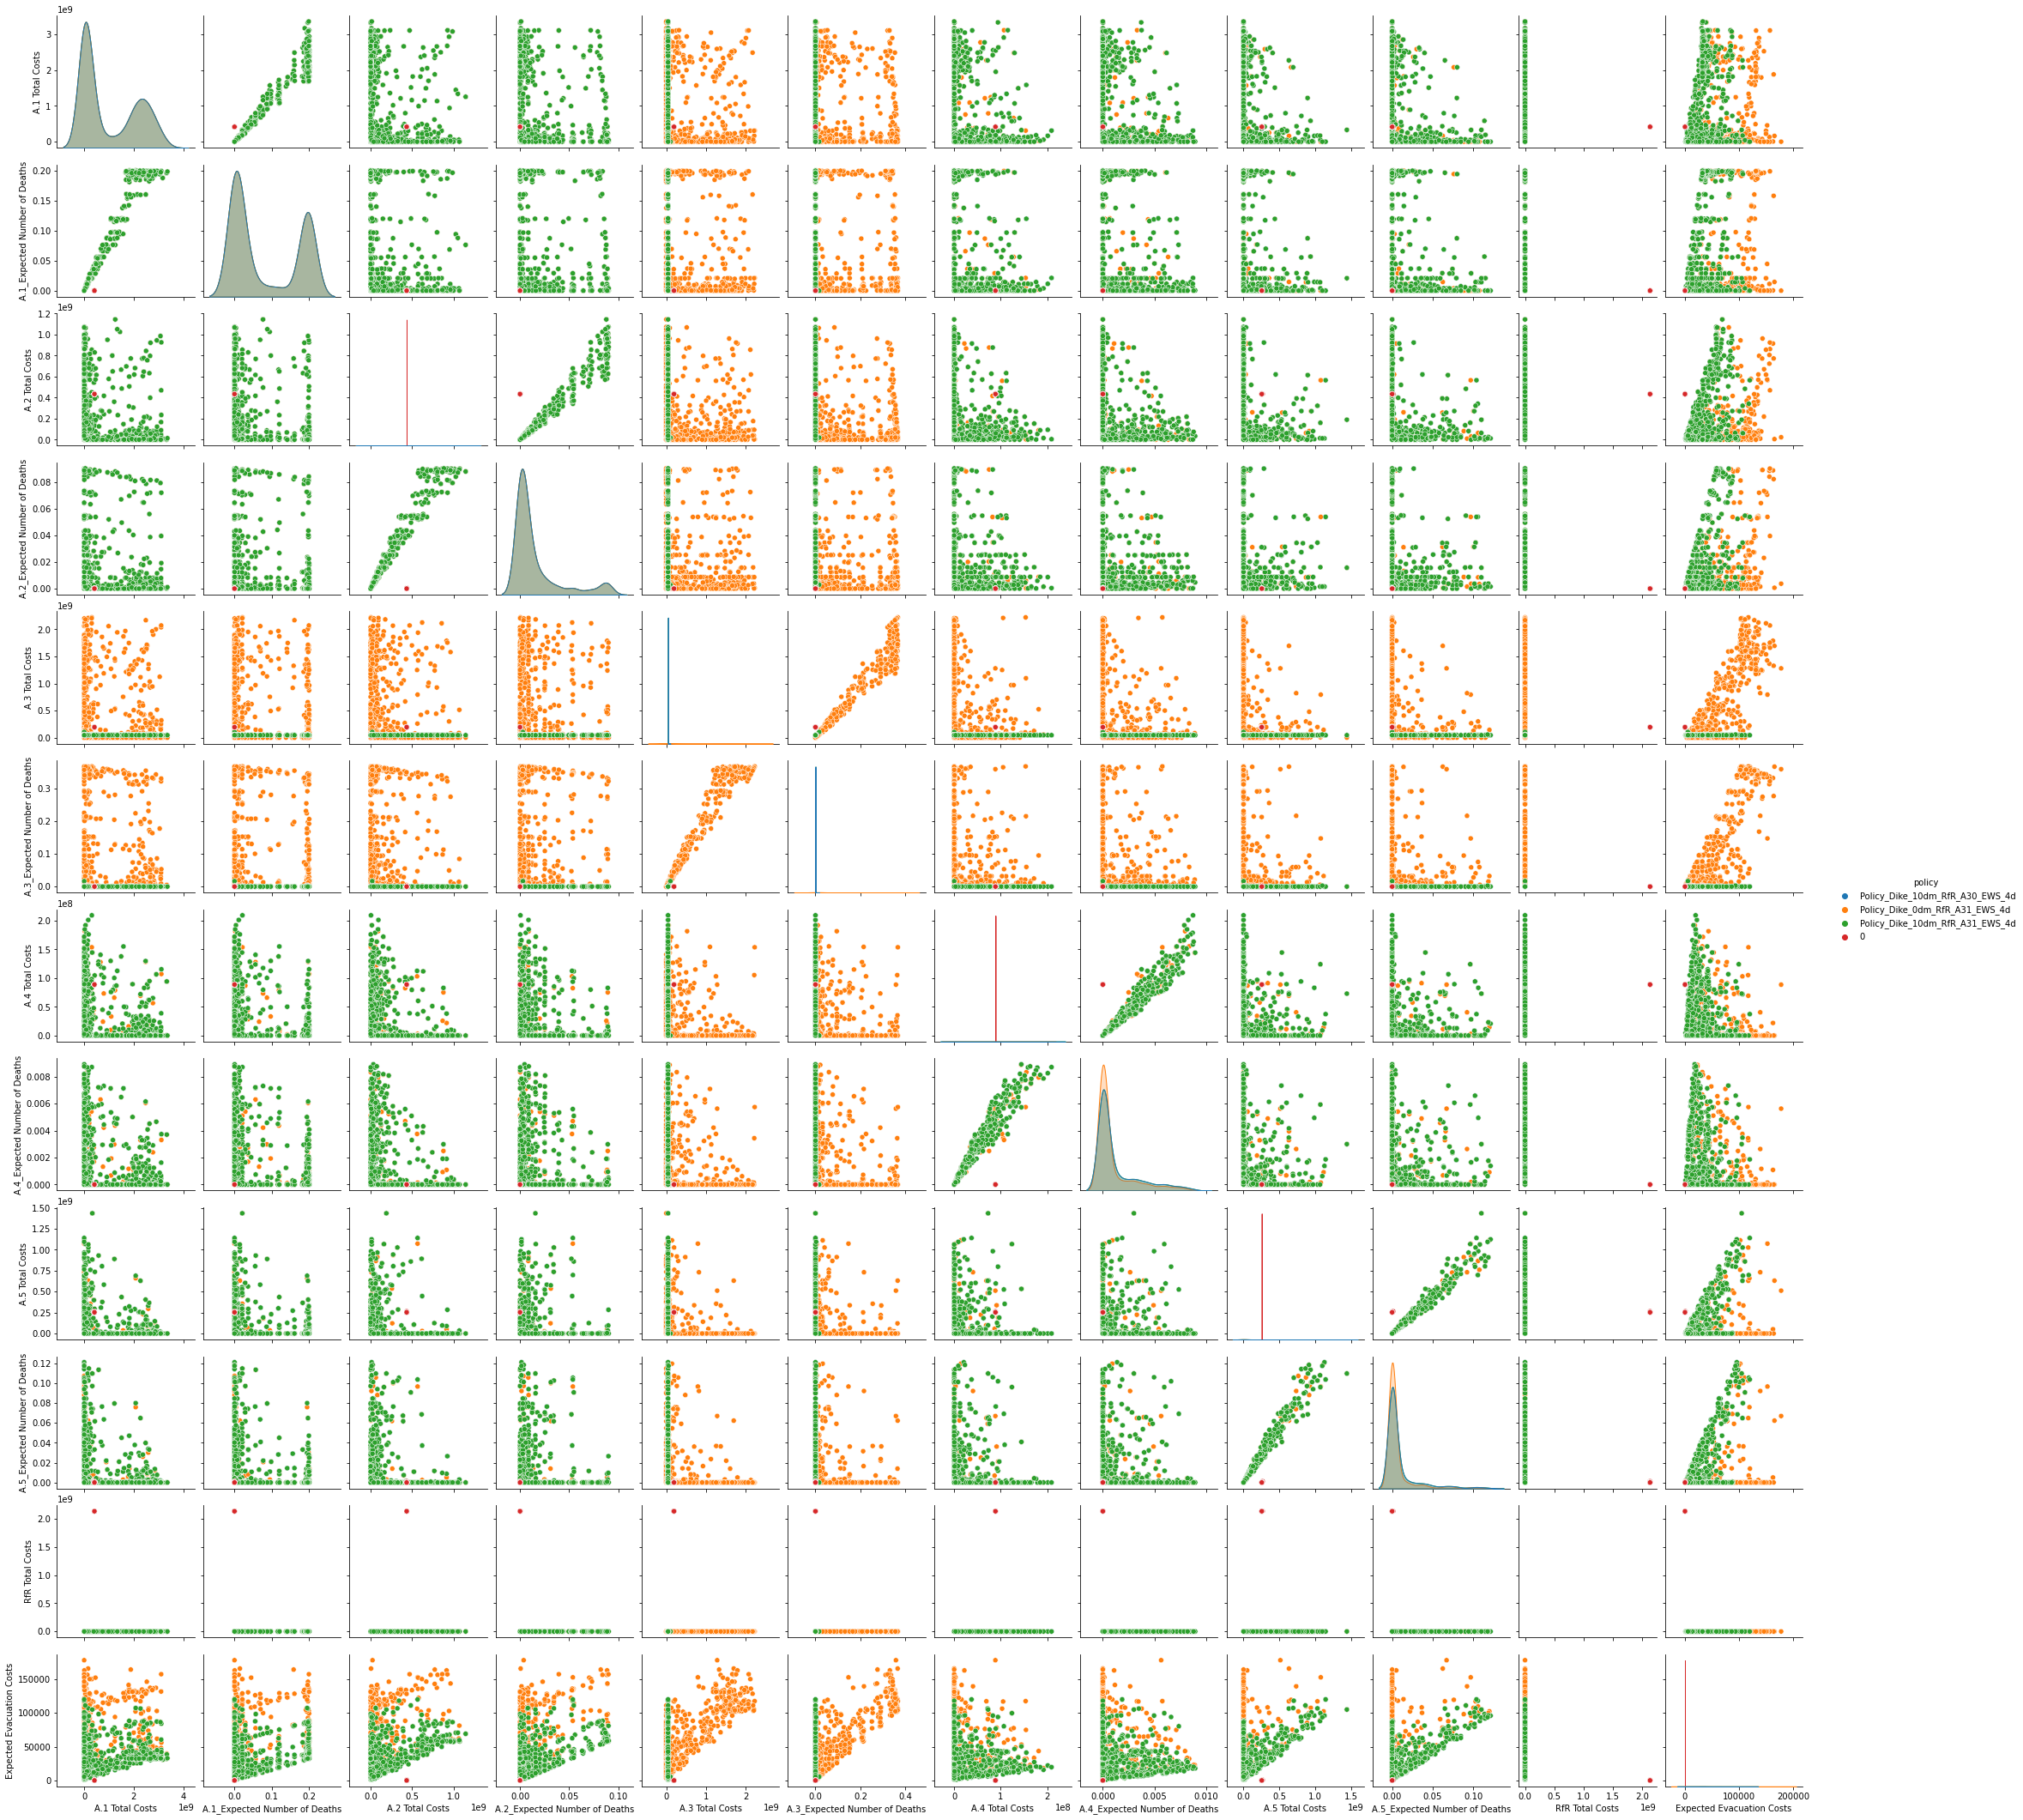

In [ ]:
experiments, outcomes = results
policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

sns_plot = sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
sns_plot.savefig('pairplot_optimize.png')
plt.show()

 On of them is the *signal to noise ratio*, which is simply the mean of a dataset divided by its standard deviation. For instance, for an outcome indicator to be maximized, we prefer a high average value across the scenarios, and a low standard deviation, implying a narrow range of uncertainty about the outcomes. Therefore, we want to maximize the signal-to-noise ratio. For an outcome indicator to be minimized, a lower mean and a lower standard deviation is preferred. Therefore the formulation should be different.

In [ ]:
#function for signal to nois ratio
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std
    

In [ ]:
experiments, outcomes = results

#first iterates over policies then over outcomes to calculate scores
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0.000000e+00,0.000000,5.425975e+13,1.213364e-11,5.741908e+00,0.000000e+00,3.167501e+11,1.488178e-15,9.023537e+13,4.834298e-11,0.0,2.613682e+01
Policy_Dike_0dm_RfR_A31_EWS_4d,1.111111e+18,0.007265,3.325576e+16,3.703850e-04,2.310851e+17,1.000571e-02,6.261095e+14,1.764601e-06,1.071966e+16,1.244016e-04,0.0,1.918547e+09
Policy_Dike_10dm_RfR_A30_EWS_4d,1.111111e+18,0.007265,3.325576e+16,3.703850e-04,8.654930e+13,1.161722e-08,9.017553e+14,2.633120e-06,1.698230e+16,2.033656e-04,0.0,6.593906e+08
Policy_Dike_10dm_RfR_A31_EWS_4d,1.111111e+18,0.007265,3.325576e+16,3.703850e-04,8.654930e+13,1.161722e-08,9.017553e+14,2.633120e-06,1.698230e+16,2.033656e-04,0.0,6.593906e+08


In [ ]:
scores.columns

Index(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs'],
      dtype='object')

c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



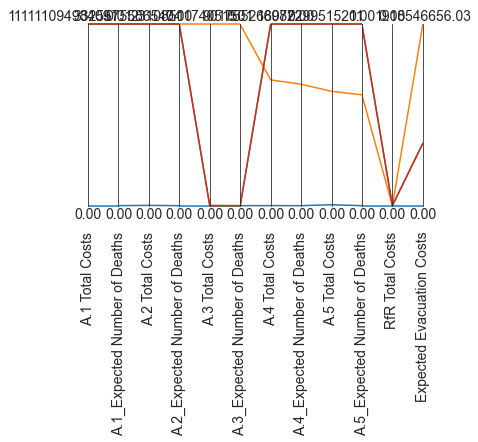

In [ ]:
#plots the s/n ratio
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis('max_P')
plt.show()

In [ ]:
limits

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0.000000e+00,0.000000,0.000000e+00,0.00000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000e+00
1,1.111111e+18,0.007265,3.325576e+16,0.00037,2.310851e+17,0.010006,9.017553e+14,0.000003,1.698230e+16,0.000203,0.0,1.918547e+09


In [ ]:
data.reset_index(inplace=True, drop=True)
data.reset_index(inplace=True)
data.columns.values[0] = "policy"

In [ ]:
data.rename({'A.1 Total Costs': '1.C', 'A.1_Expected Number of Deaths': '1.D',
       'A.2 Total Costs': '2.C', 'A.2_Expected Number of Deaths': '2.D' , 'A.3 Total Costs': '3.C',
       'A.3_Expected Number of Deaths': '3.D', 'A.4 Total Costs': '4.C',
       'A.4_Expected Number of Deaths': '4.D', 'A.5 Total Costs': '5.C',
       'A.5_Expected Number of Deaths': '5.D'},axis=1, inplace=True)

In [ ]:
data

,policy,1.C,1.D,2.C,2.D,3.C,3.D,4.C,4.D,5.C,5.D,RfR Total Costs,Expected Evacuation Costs
0,0,0,0,54259751293104,0,5,0,316750106160,0,90235372732579,0,0,26
1,1,1111110949840914176,0,33255755865474404,0,231085117405150976,0,626109483413402,0,10719660347372692,0,0,1918546656
2,2,1111110949840914176,0,33255755865474404,0,86549301547281,0,901755268077261,0,16982299515211588,0,0,659390592
3,3,1111110949840914176,0,33255755865474404,0,86549301547281,0,901755268077261,0,16982299515211588,0,0,659390592


In [ ]:
data['1.C']=data['1.C'].astype('int64')

In [ ]:
data2 = data.iloc[::-1,:]

In [ ]:
data[['1.C', '1.D', '2.C', '2.D', '3.C', '3.D', '4.C', '4.D', '5.C',
       '5.D', 'RfR Total Costs', 'Expected Evacuation Costs']] = data[['1.C', '1.D', '2.C', '2.D', '3.C', '3.D', '4.C', '4.D', '5.C',
       '5.D', 'RfR Total Costs', 'Expected Evacuation Costs']].astype('int64')

In [ ]:
limits = parcoords.get_limits(data.iloc[:,1::])
dimensionlist = []

for column in limits:
    print(column)
    lower=0
    upper=limits[column].iloc[1]
    if upper>0:
        dimensionlist.append(dict(range = [lower,upper],
                label = column, values = data[column].values, tickformat = "~g"))
    else:
        dimensionlist.append(dict(range = [lower,1],
                label = column, values = data[column].values, tickformat = "~g"))


1.C
1111110949840914176
1.D
0
2.C
33255755865474404
2.D
0
3.C
231085117405150976
3.D
0
4.C
901755268077261
4.D
0
5.C
16982299515211588
5.D
0
RfR Total Costs
0
Expected Evacuation Costs
1918546656


In [ ]:
limits

,1.C,1.D,2.C,2.D,3.C,3.D,4.C,4.D,5.C,5.D,RfR Total Costs,Expected Evacuation Costs
0,0,0,54259751293104,0,5,0,316750106160,0,90235372732579,0,0,26
1,1111110949840914176,0,33255755865474404,0,231085117405150976,0,901755268077261,0,16982299515211588,0,0,1918546656


In [ ]:
limits

,1.C,1.D,2.C,2.D,3.C,3.D,4.C,4.D,5.C,5.D,RfR Total Costs,Expected Evacuation Costs
0,0,0,54259751293104,0,5,0,316750106160,0,90235372732579,0,0,26
1,1111110949840914176,0,33255755865474404,0,231085117405150976,0,901755268077261,0,16982299515211588,0,0,1918546656


In [ ]:
dimensionlist

[{'range': [0, 1111110949840914176],
  'label': '1.C',
  'values': array([                  0, 1111110949840914176, 1111110949840914176,
         1111110949840914176], dtype=int64),
  'tickformat': '~g'},
 {'range': [0, 1],
  'label': '1.D',
  'values': array([0, 0, 0, 0], dtype=int64),
  'tickformat': '~g'},
 {'range': [0, 33255755865474404],
  'label': '2.C',
  'values': array([   54259751293104, 33255755865474404, 33255755865474404,
         33255755865474404], dtype=int64),
  'tickformat': '~g'},
 {'range': [0, 1],
  'label': '2.D',
  'values': array([0, 0, 0, 0], dtype=int64),
  'tickformat': '~g'},
 {'range': [0, 231085117405150976],
  'label': '3.C',
  'values': array([                 5, 231085117405150976,     86549301547281,
             86549301547281], dtype=int64),
  'tickformat': '~g'},
 {'range': [0, 1],
  'label': '3.D',
  'values': array([0, 0, 0, 0], dtype=int64),
  'tickformat': '~g'},
 {'range': [0, 901755268077261],
  'label': '4.C',
  'values': array([   316750106

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure(data=
    go.Parcoords(line = dict(color = data['policy'],
                   colorscale = [[0,'yellow'],[0.5,'lightseagreen'],[1,'red']], showscale=True),
                   dimensions= dimensionlist
                             ))
fig.show()

<AxesSubplot:>

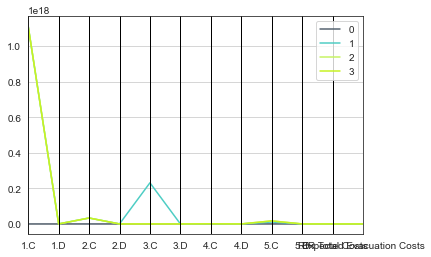

In [ ]:
pd.plotting.parallel_coordinates(

    data, 'policy', color=('#556270', '#4ECDC4', '#C7F464', '#C7F321')

)

Another robustness metric is **maximum regret**, calculated again for each policy and for each outcome indicator. *Regret* is defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the berformance of a no-regret (i.e. best possible result in that scenario) or reference policy. The *maximum regret*  is then the maximum of such regret values across all scenarios. We of course favor policy options with low *maximum regret* values. 

In [ ]:
#function to calculate regret
def calculate_regret(data, best):
    return np.abs(best-data)

In [ ]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

C:\Users\hanna\AppData\Local\Temp\ipykernel_20220\477790474.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\hanna\AppData\Local\Temp\ipykernel_20220\477790474.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\hanna\AppData\Local\Temp\ipykernel_20220\477790474.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\hanna\AppData\Local\Temp\ipykernel_20220\47779

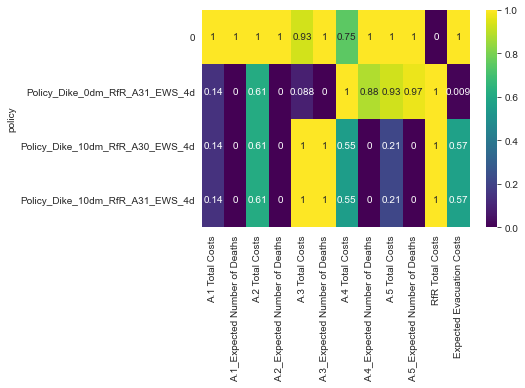

In [ ]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\ema_workbench\analysis\parcoords.py:260: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


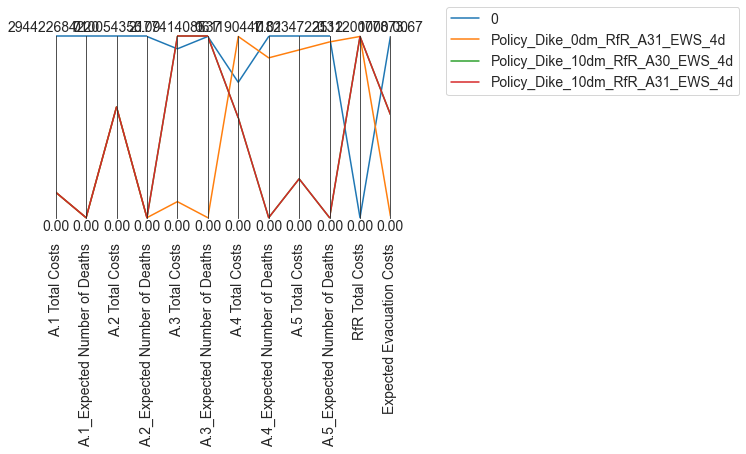

In [ ]:

colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

Distribution  of regret

In [ ]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

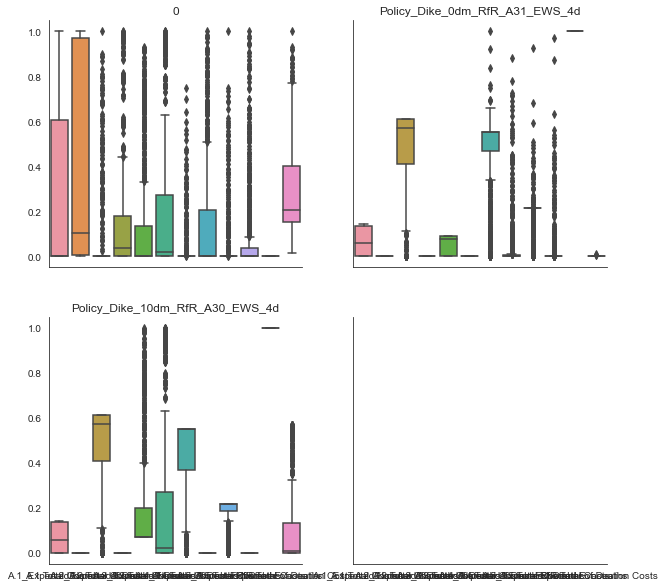

In [ ]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1],
        axes[1,0],]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()